<a href="https://colab.research.google.com/github/veyselalevcan/Data_Pipeline_ML_Diabet/blob/main/Data_Pipeline_ML_Diabet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [89]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


In [90]:
df = pd.read_csv("/content/diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [91]:
# Helpers Functions
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.75, 0.90, 1]).T)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [92]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [93]:
df['BloodPressure'].replace(0, np.nan, inplace=True)
df['BloodPressure'].interpolate(method='linear', inplace=True)
df['SkinThickness'].replace(0, np.nan, inplace=True)
df['SkinThickness'].interpolate(method='linear', inplace=True)

In [94]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(f'Kategorik değişkenler: {cat_cols}')
print(f'Numerik değişkenler: {num_cols}')
print(f'Kategorik fakat kardinal değişkenler: {cat_but_car}')

Kategorik değişkenler: ['Outcome']
Numerik değişkenler: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Kategorik fakat kardinal değişkenler: []


In [95]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

         Outcome      Ratio
Outcome                    
0            500  65.104167
1            268  34.895833
##########################################


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


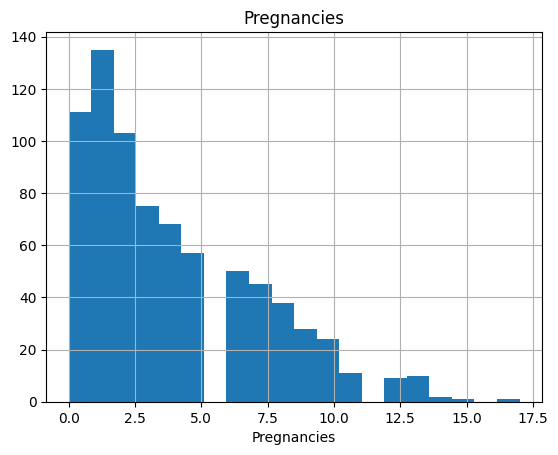

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


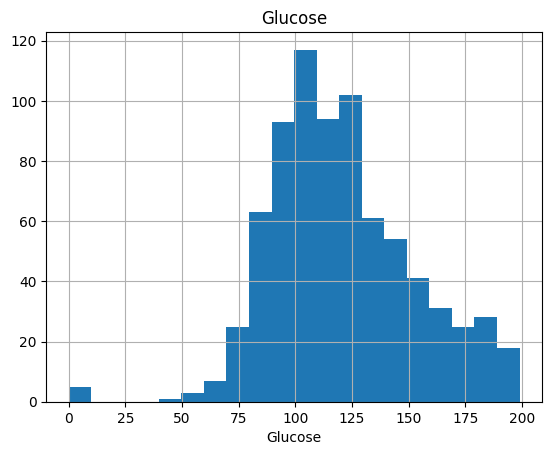

count    768.000000
mean      72.330729
std       12.207864
min       24.000000
5%        52.000000
10%       58.000000
20%       62.000000
30%       66.000000
40%       70.000000
50%       72.000000
60%       75.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


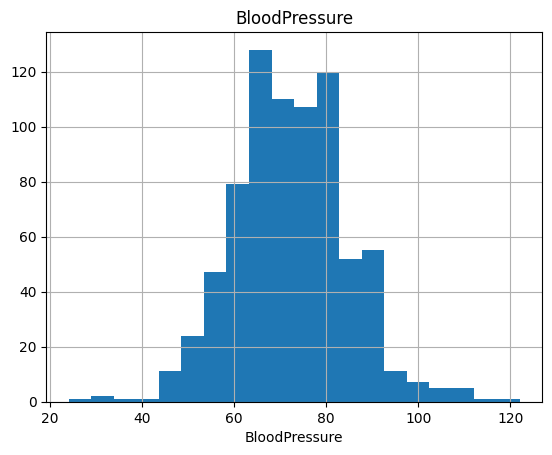

count    768.000000
mean      29.080078
std        9.887474
min        7.000000
5%        14.000000
10%       17.000000
20%       20.000000
30%       23.000000
40%       26.700000
50%       29.000000
60%       31.000000
70%       34.000000
80%       37.000000
90%       41.000000
95%       45.000000
99%       52.000000
max       99.000000
Name: SkinThickness, dtype: float64


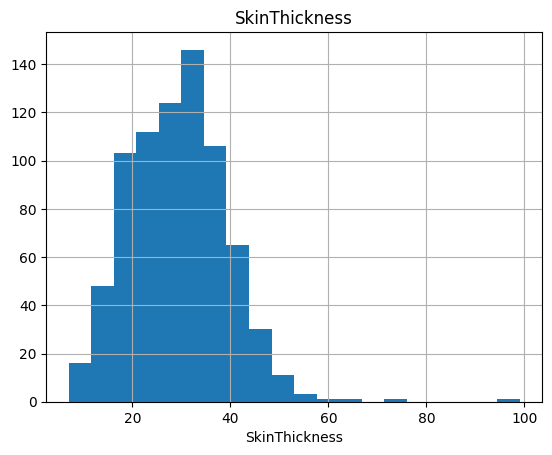

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


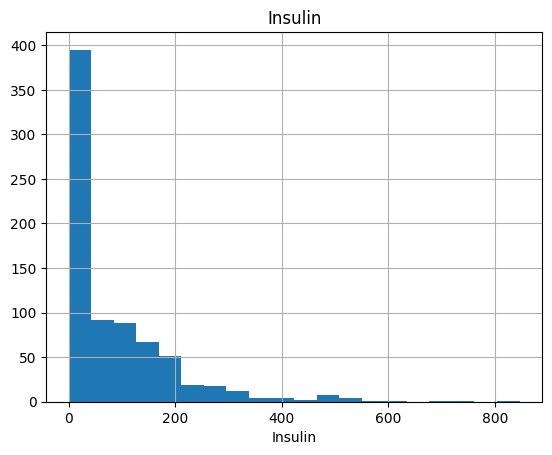

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


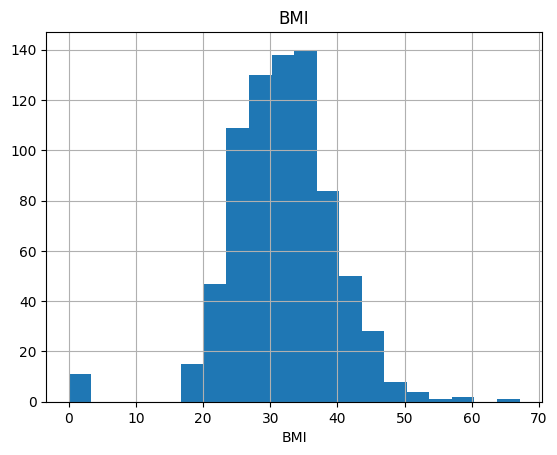

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


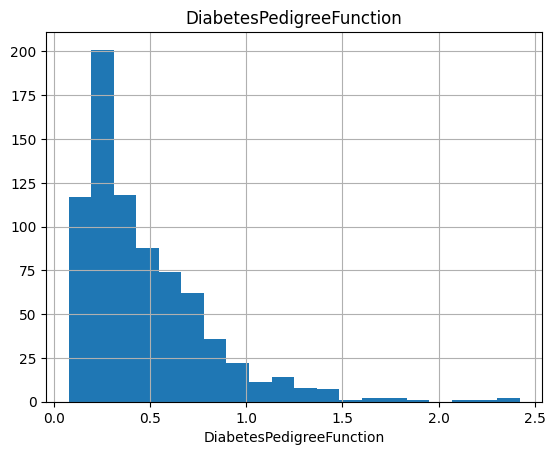

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


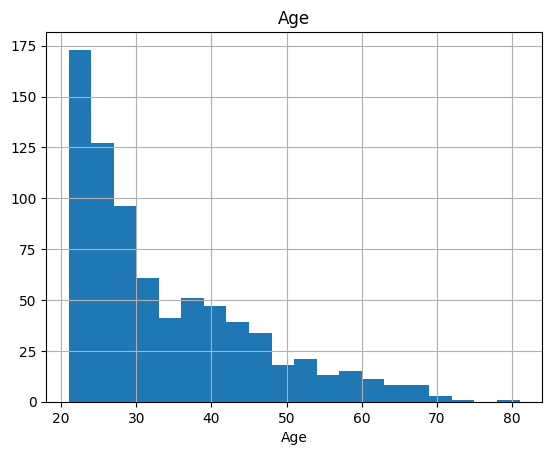

In [96]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

for col in num_cols:
      num_summary(df, col, plot=True)

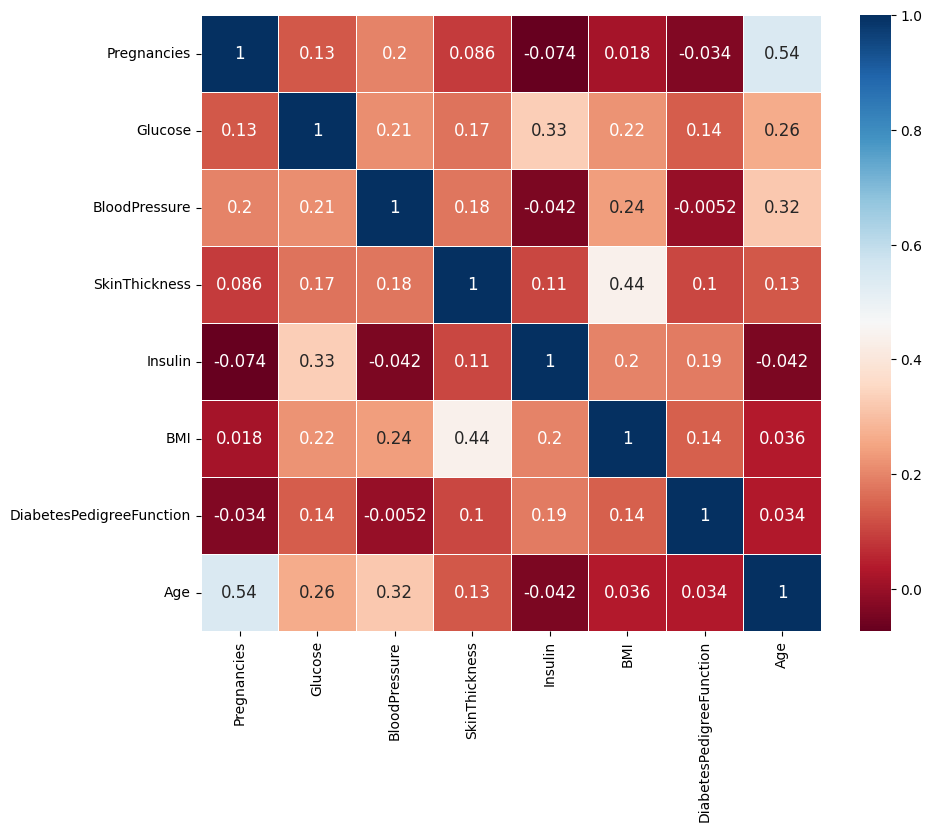

In [97]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

In [98]:
# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            70.894000
1            75.011194


         SkinThickness
Outcome               
0            27.659033
1            31.731281


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




In [99]:
# 2. Data Preprocessing & Feature Engineering
################################################

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,0,33.6,0.627,50,1
1,1,85,66.0,29.0,0,26.6,0.351,31,0
2,8,183,64.0,26.0,0,23.3,0.672,32,1
3,1,89,66.0,23.0,94,28.1,0.167,21,0
4,0,137,40.0,35.0,168,43.1,2.288,33,1


In [100]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72.0,35.0,0,33.6,0.627,50,1
1,1,85,66.0,29.0,0,26.6,0.351,31,0
2,8,183,64.0,26.0,0,23.3,0.672,32,1
3,1,89,66.0,23.0,94,28.1,0.167,21,0
4,0,137,40.0,35.0,168,43.1,2.288,33,1


In [101]:
df.groupby('OUTCOME').agg({'GLUCOSE': ['min','mean', 'max', 'count']})

GLUCOSE                       
            min        mean  max count
OUTCOME                               
0             0  109.980000  197   500
1             0  141.257463  199   268

In [102]:
# Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])
df['NEW_GLUCOSE_CAT'].value_counts()

df.groupby('OUTCOME').agg({'NEW_GLUCOSE_CAT': 'value_counts'})

NEW_GLUCOSE_CAT
OUTCOME NEW_GLUCOSE_CAT                 
0       normal                       438
        prediabetes                   62
1       prediabetes                  135
        normal                       133

In [103]:
# Age
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

df.groupby('OUTCOME').agg({'NEW_AGE_CAT': 'value_counts'})

NEW_AGE_CAT
OUTCOME NEW_AGE_CAT             
0       young                362
        middleage            105
        old                   33
1       young                126
        middleage            125
        old                   17

In [104]:
# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, df['BMI'].max()],
                             labels=["underweight", "healty", "overweight", "obese"])

df.groupby('OUTCOME').agg({'NEW_BMI_RANGE': 'value_counts'})

NEW_BMI_RANGE
OUTCOME NEW_BMI_RANGE               
0       obese                    253
        overweight               139
        healty                    95
        underweight               13
1       obese                    219
        overweight                40
        healty                     7
        underweight                2

In [105]:
# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

df.groupby('OUTCOME').agg({'NEW_BLOODPRESSURE': 'value_counts'})

NEW_BLOODPRESSURE
OUTCOME NEW_BLOODPRESSURE                   
0       normal                           381
        hs1                               88
        hs2                               31
1       normal                           177
        hs1                               62
        hs2                               29

In [106]:
#check_df(df)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PREGNANCIES,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
GLUCOSE,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BLOODPRESSURE,768.0,72.330729,12.207864,24.000,64.00000,72.0000,80.00000,122.00
SKINTHICKNESS,768.0,29.080078,9.887474,7.000,22.00000,29.0000,36.00000,99.00
INSULIN,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DIABETESPEDIGREEFUNCTION,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
AGE,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
OUTCOME,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [107]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(f'Kategorik değişkenler: {cat_cols}')
print(f'Numerik değişkenler: {num_cols}')
print(f'Kategorik fakat kardinal değişkenler: {cat_but_car}')

Kategorik değişkenler: ['NEW_AGE_CAT', 'OUTCOME', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']
Numerik değişkenler: ['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE']
Kategorik fakat kardinal değişkenler: []


In [108]:
for col in cat_cols:
    cat_summary(df, col)

             NEW_AGE_CAT      Ratio
NEW_AGE_CAT                        
young                488  63.541667
middleage            230  29.947917
old                   50   6.510417
##########################################
         OUTCOME      Ratio
OUTCOME                    
0            500  65.104167
1            268  34.895833
##########################################
                 NEW_GLUCOSE_CAT      Ratio
NEW_GLUCOSE_CAT                            
normal                       571  74.348958
prediabetes                  197  25.651042
##########################################
               NEW_BMI_RANGE      Ratio
NEW_BMI_RANGE                          
obese                    472  61.458333
overweight               179  23.307292
healty                   102  13.281250
underweight               15   1.953125
##########################################
                   NEW_BLOODPRESSURE     Ratio
NEW_BLOODPRESSURE                             
normal                    

In [109]:
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.317204
hs1                   0.413333
hs2                   0.483333




<ipython-input-91-33b623eccdef>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
<ipython-input-91-33b623eccdef>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
<ipython-input-91-33b623eccdef>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default an

In [110]:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [112]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

KeyError: "None of [Index(['NEW_AGE_CAT', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE'], dtype='object')] are in the [columns]"

In [114]:
df.columns = [col.upper() for col in df.columns]
df.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PREDIABETES', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')

In [115]:
# Son güncel değişken türlerimi tutuyorum.
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [118]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))


PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS True
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [120]:
replace_with_thresholds(df, "INSULIN")
replace_with_thresholds(df, "SKINTHICKNESS")

In [121]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [122]:

# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)


In [125]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                   bool
NEW_AGE_CAT_YOUNG                 bool
NEW_GLUCOSE_CAT_PREDIABETES       bool
NEW_BMI_RANGE_HEALTY              bool
NEW_BMI_RANGE_OVERWEIGHT          bool
NEW_BMI_RANGE_OBESE               bool
NEW_BLOODPRESSURE_HS1             bool
NEW_BLOODPRESSURE_HS2             bool
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [126]:
# 3. Base Models
######################################################

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")


Base Models....
accuracy: 0.7552 (LR) 
accuracy: 0.7578 (KNN) 
accuracy: 0.7487 (SVC) 
accuracy: 0.6823 (CART) 
accuracy: 0.7682 (RF) 
accuracy: 0.7565 (Adaboost) 
accuracy: 0.7526 (GBM) 


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy: 0.7435 (XGBoost) 
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [127]:
# 4. Automated Hyperparameter Optimization
######################################################

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]



In [128]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.7961
roc_auc (After): 0.82
KNN best params: {'n_neighbors': 14}

########## CART ##########
roc_auc (Before): 0.6495
roc_auc (After): 0.7605
CART best params: {'max_depth': 4, 'min_samples_split': 27}

########## RF ##########
roc_auc (Before): 0.825


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

roc_auc (After): 0.8312
RF best params: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


roc_auc (Before): 0.8055


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


roc_auc (After): 0.8118
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [129]:
# 5. Stacking & Ensemble Learning
######################################################

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [133]:
voting_clf

VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=14)),
                             ('RF',
                              RandomForestClassifier(max_depth=8,
                                                     max_features=7,
                                                     min_samples_split=15,
                                                     n_estimators=200)),
                             ('LightGBM',
                              LGBMClassifier(learning_rate=0.01,
                                             n_estimators=500))],
                 voting='soft')

In [132]:
# 6. Prediction for a New Observation
######################################################

print(X.columns)
random_user = X.sample(1, random_state=45)
print(voting_clf.predict(random_user))

joblib.dump(voting_clf, "voting_clf2.pkl")

new_model = joblib.load("voting_clf2.pkl")
print(f'Predict New:', new_model.predict(random_user))


Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PREDIABETES', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')
[1]
Predict New: [1]


In [134]:
# Pipeline Main Function
################################################

def main():
    #df = pd.read_csv("datasets/diabetes.csv")
    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)
    base_models(X, y)
    best_models = hyperparameter_optimization(X, y)
    voting_clf = voting_classifier(best_models, X, y)
    joblib.dump(voting_clf, "voting_clf.pkl")
    return voting_clf

if __name__ == "__main__":
    print("İşlem başladı")
    main()

İşlem başladı
Base Models....
roc_auc: 0.837 (LR) 
roc_auc: 0.7961 (KNN) 
roc_auc: 0.8312 (SVC) 
roc_auc: 0.6593 (CART) 
roc_auc: 0.8262 (RF) 
roc_auc: 0.8192 (Adaboost) 
roc_auc: 0.8218 (GBM) 


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


roc_auc: 0.8055 (XGBoost) 
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

roc_auc (After): 0.8324
RF best params: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 20, 'n_estimators': 300}

########## XGBoost ##########


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


roc_auc (Before): 0.8118


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


roc_auc (After): 0.8118
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [